In [1]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [12]:
df = pd.read_csv('data/tovar_moving.csv', index_col='date', parse_dates=['date'])
df.head()

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0


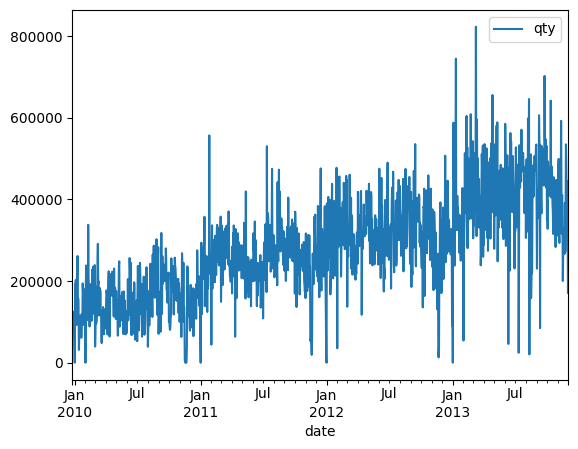

In [16]:
df.plot();

In [13]:
train_data = df['qty'][:len(df)-1]
test_data = df['qty'][len(df)-1:]

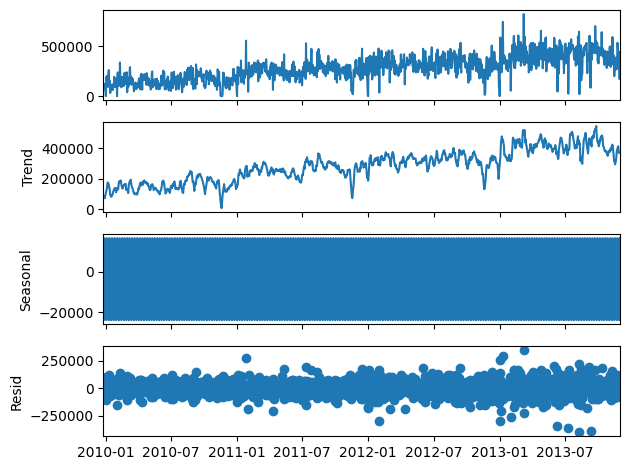

In [14]:
# Посмотрим на линию треда и сезонность
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

In [41]:
# построим модель экспоненциального сглаживания на обучающем наборе
ses = SimpleExpSmoothing(train_data)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
forecast = model.forecast(1)
print('fact: {:.0f}, forecast: {:.0f}'.format(test_data.values[0], forecast[0]))

fact: 423846, forecast: 225016


C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [44]:
# проверим стационарность на исхожных данных
test = adfuller(df)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Ряд не является стационарным')
else:
    print ('Ряд является стационарным')

adf:  -2.2379751493990576
p-value:  0.1927523955484084
Critical values:  {'1%': -3.4349700122033804, '5%': -2.8635804131233096, '10%': -2.567856305330816}
Ряд не является стационарным


**Вывод:** ряд не является стационарным.

In [32]:
# продифференцируем данные
df_diff = df.diff().dropna()

In [45]:
# Проверим на стационарность дифференцированный ряд
test1 = adfuller(df_diff)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('Ряд не является стационарным')
else:
    print ('Ряд является стационарным')

adf:  -13.82183986522668
p-value:  7.878856681049073e-26
Critical values:  {'1%': -3.4349700122033804, '5%': -2.8635804131233096, '10%': -2.567856305330816}
Ряд является стационарным


**Вывод:** нам потребуется модель 1 порядка.

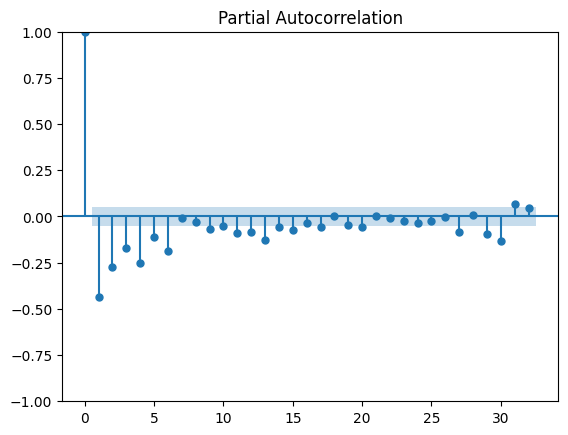

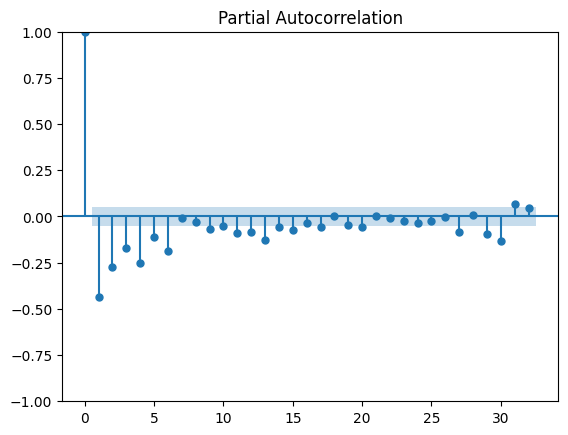

In [42]:
# построим график частичной автокорреляции
plot_pacf(df_diff)

**Вывод:** согласно графику лаг составит 6

In [36]:
ar_model = AutoReg(train_data, lags=6).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1438
Model:                     AutoReg(6)   Log Likelihood              -18221.056
Method:               Conditional MLE   S.D. of innovations          81248.064
Date:                Thu, 20 Jun 2024   AIC                          36458.111
Time:                        22:04:24   BIC                          36500.246
Sample:                    12-31-2009   HQIC                         36473.844
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.047e+04   6160.175      4.946      0.000    1.84e+04    4.25e+04
qty.L1         0.3074      0.026     11.654      0.000       0.256       0.359
qty.L2         0.1582      0.027      5.835      0.0

C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [40]:
pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)
print(round(pred, 0))

2013-12-02    318174.0
Freq: D, dtype: float64


C:\Users\vadim.kopytko\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\deterministic.py:307: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [43]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_data, pred) < mean_squared_error(test_data, forecast)

True